In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default') # set style (colors, background, size, gridlines etc.) # ggplot
plt.rcParams['figure.figsize'] = 8, 4 # set default size of plots
plt.rcParams.update({'font.size': 18})

import scraping_class
logfile = 'log.txt' ## name your log file.
connector = scraping_class.Connector(logfile)

from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

In [118]:
#pip install cpi

In [119]:
movies = pd.read_csv('IMDb movies.csv')
actors = pd.read_csv('IMDb names.csv')
ratings = pd.read_csv('IMDb ratings.csv')
role = pd.read_csv('IMDb title_principals.csv')

##### IMDb - Remove duplicates and all years before 1990

In [120]:
movies_90 = movies[movies.year >= 1990] # (53368, 22)
#movies_90 = movies.drop(movies[movies['year'] < 1990].index)
movies_us = movies[movies.country == 'USA']
movies_us_90 = movies_us[movies_us.year >= 1990]
movies_90['title'] = movies_90['title'].astype(str)
movies_90 = movies_90.drop_duplicates(subset = 'title')
mocies_us_90 = movies_us_90.drop_duplicates(subset = 'title')

/Users/ea/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


##### RT - Remove duplicates 

In [121]:

df_RT = pd.read_csv('RT.csv').drop_duplicates(subset = 'title')
df_90 = pd.merge(movies_90,df_RT,how='inner',on='title')
df_90 = df_90.drop_duplicates()
df_90_us = pd.merge(movies_us_90,df_RT,how='inner',on='title')
df_90_us = df_90_us.drop_duplicates()

In [122]:
# **** Remove NaN ****
df_90_income = df_90.dropna(subset = ['worlwide_gross_income']).reset_index(drop=True).drop_duplicates()
df_us = df_90_us[df_90_us['worlwide_gross_income'].notna()].reset_index(drop=True)

#df_90_income.dtypes
#df_90_income.head()
#print(df_90_income.shape)
#df_90
#df_90_income

##### Cleaning dataset and adjusting income and budget for inflation (CPI)

In [123]:
import cpi
#cpi.update()

def inflate_column(data, column):
    '''Inflate monetary figures from a given year to their 2018 values'''
    return data.apply(lambda x: cpi.inflate(x[column], x.year), axis=1)

In [124]:
df_90_income['worldwide_gross_income'] = df_90_income['worlwide_gross_income']\
                                        .apply(lambda x:x[1:] if x and x[:1]== '$' else None)
df_90_income = df_90_income.drop('worlwide_gross_income', axis=1)
df_90_income = df_90_income.dropna(subset = ['worldwide_gross_income'])

In [125]:
df_90_income = df_90_income.dropna(subset = ['budget'])
df_90_income['budget'] = df_90_income['budget'].apply(lambda x:x[1:] if x and x[:1]== '$' else None)

df_90_income = df_90_income.dropna(subset = ['usa_gross_income'])
df_90_income['usa_gross_income'] = df_90_income['usa_gross_income']\
                                        .apply(lambda x:x[1:] if x and x[:1]== '$' else None)

In [127]:
df_90_income = df_90_income.reset_index(drop=True).drop_duplicates()

df_90_income.worldwide_gross_income = df_90_income.worldwide_gross_income.astype(int)
df_90_income = df_90_income[df_90_income.year <= 2018]
df_90_income['adjusted_wgi'] = inflate_column(df_90_income, 'worldwide_gross_income')

df_budget = df_90_income.dropna(subset = ['budget']).copy()
df_budget.budget = df_budget.budget.astype(int)

df_budget['adjusted_budget'] = inflate_column(df_budget, 'budget')
df_budget['net_income'] = df_budget.adjusted_wgi - df_budget.adjusted_budget
#df_90_income.dtypes
#df_budget

##### Clean US dataset for valuta (dollar sign)

In [128]:
df_us['wgi'] = df_us['worlwide_gross_income'].replace({'\$':''}, regex = True)
df_us['budget'] = df_us['budget'].replace({'\$':''}, regex = True)
df_us['usa_gross_income'] = df_us['usa_gross_income'].replace({'\$':''}, regex = True)


In [129]:
#len(df_us[df_us.year==2019])
df_us.wgi = df_us.wgi.astype(int)
df_us = df_us[df_us.year <= 2018]
df_us['adjusted'] = inflate_column(df_us, 'wgi')
#df_us

##### Seperating data into features (have greater flexibility for project when predicting)

In [65]:
df_x = df_90_income[['title', 'year', 'date_published', 'genre', 'duration','country', 'director', 'actors', 'budget','production_company','writer']]
df_y = df_90_income[[ 'avg_vote', 'metascore','tomatometer_score', 'audience_score','usa_gross_income', 'worldwide_gross_income']]

In [66]:
df_x.to_csv('inputInfo_X.csv', encoding='utf-8',index=False)

In [67]:
df_y.to_csv('inputInfo_Y.csv', encoding='utf-8',index=False)

In [130]:
x = pd.read_csv("inputInfo_X.csv")

In [131]:
y = pd.read_csv("inputInfo_Y.csv")

In [132]:
def convert_to_array(rating):
    rating = str(rating)
    rating = rating.lower()
    rating = rating.split(",")
    return rating

##### Converting columns with multiple string entries to a list. This will assist for converting each string entry to dummy variables

In [133]:
x["genre"]= x["genre"].apply(lambda x: convert_to_array(x))
x["country"] = x["country"].apply(lambda x: convert_to_array(x))
x["director"] = x["director"].apply(lambda x: convert_to_array(x))
x["actors"] = x["actors"].apply(lambda x: convert_to_array(x))
x["title"] = x["title"].apply(lambda x: convert_to_array(x))
x["production_company"] = x["production_company"].apply(lambda x: convert_to_array(x))
x["writer"] = x["writer"].apply(lambda x: convert_to_array(x))

##### Converting published date to months

In [134]:
x["date_published"] = x["date_published"].apply(lambda x: pd.to_datetime(x).month)

##### Creating dummy variables 

In [135]:
from sklearn.preprocessing import MultiLabelBinarizer
MLB = MultiLabelBinarizer()

In [136]:
actor_dummy = pd.DataFrame(MLB.fit_transform(x["actors"]),columns = MLB.classes_,index=x.index)
genre_dummy = pd.DataFrame(MLB.fit_transform(x["genre"]),columns=MLB.classes_, index=x.index)
country_dummy = pd.DataFrame(MLB.fit_transform(x["country"]),columns = MLB.classes_,index=x.index)
director_dummy = pd.DataFrame(MLB.fit_transform(x["director"]),columns = MLB.classes_,index=x.index)

In [137]:
genre_dummy.head()

,action,adventure,biography,comedy,crime,drama,family,fantasy,history,horror,...,family,fantasy,horror,music,musical,mystery,romance,sci-fi,thriller,western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Looking at the predictor values

In [138]:
y_2 = y[["tomatometer_score","audience_score","metascore","avg_vote","usa_gross_income","worldwide_gross_income"]]

##### Clean dataset further: Remove % from score

In [139]:
y_2['tomatometer_score'] = y_2['tomatometer_score'].replace({'\%':''}, regex = True)
y_2['audience_score'] = y_2['audience_score'].replace({'\%':''}, regex = True)


##### Converting ratings to float 


In [140]:
y_2['tomatometer_score']= y_2['tomatometer_score'].astype(float)
y_2['audience_score']= y_2['audience_score'].astype(float)

#y_2.info()

##### Converting the audience and user rating to binary. 

In [141]:
y_2["t_rating"] = y_2["tomatometer_score"].apply(lambda x: 1 if x > 60.0 else 0)
y_2["audience_score"] = y_2["audience_score"].apply(lambda x: 1 if x > 60.0 else 0) 

##### Data Visualization

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

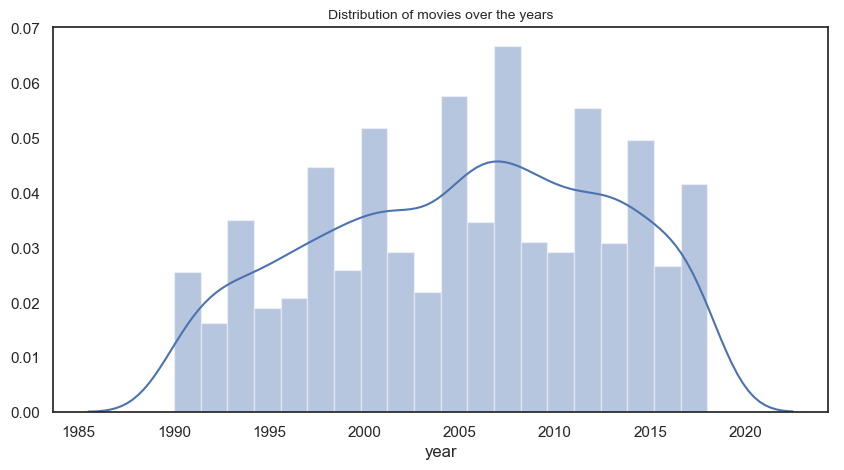

In [151]:
fig, ax = plt.subplots(figsize = (10,5))
sns.distplot(df_90_income.year, bins = 20);
plt.title("Distribution of movies over the years", size = 10);

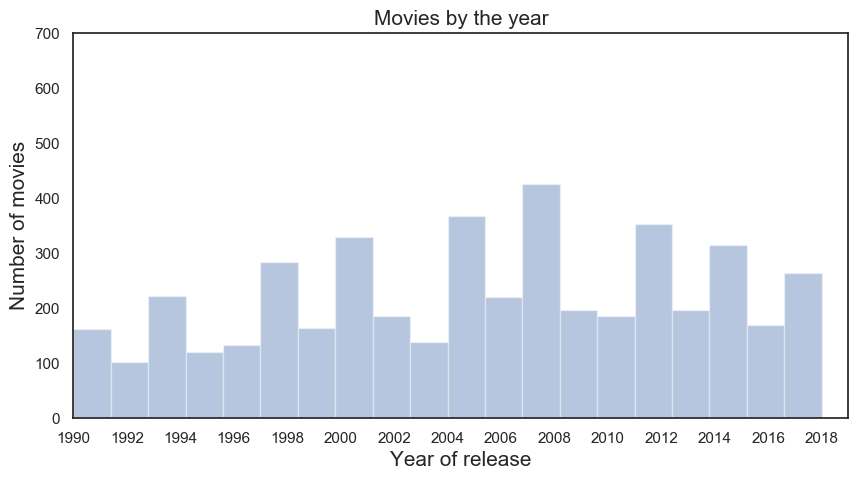

In [152]:
sns.set(style="white")

plt.figure(figsize=(10,5))
plt.title('Movies by the year', size=15)
sns.distplot(df_90_income.year, kde=False)
plt.ylabel('Number of movies', size=15)
plt.xlabel('Year of release',size=15)
plt.axis([1990, 2019, 0, 700])
plt.xticks(np.arange(1990, 2019, step=2))
plt.show()

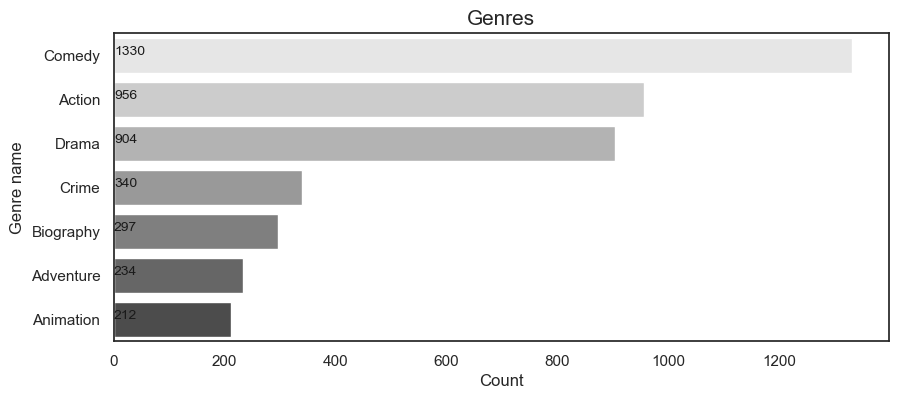

In [153]:
# Overview of the different genres 
df_90_income['first_genre'] = df_90_income['genre'].str.split(',').str[0]

a = plt.cm.binary

plt.figure(figsize=(10,4))
count = df_90_income['first_genre'].value_counts()[:7]
sns.barplot(count.values, count.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7)])
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=10)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre name', fontsize=12)
plt.title("Genres", fontsize=15)
plt.show()

In [154]:
# Overview of movies with highest scores 
top_scored = df_90_income.sort_values(["tomatometer_score","audience_score","metascore","avg_vote"], ascending=False)[
    ["title", "director", "tomatometer_score","audience_score","metascore","avg_vote"]]
top_scored.index = range(len(df_90_income))
top_scored.head(n=10)

,title,director,tomatometer_score,audience_score,metascore,avg_vote
0,L.A. Confidential,Curtis Hanson,99%,94%,90.0,8.2
1,How to Train Your Dragon,"Dean DeBlois, Chris Sanders",99%,91%,74.0,8.1
2,Finding Nemo,"Andrew Stanton, Lee Unkrich",99%,86%,90.0,8.1
3,Selma,Ava DuVernay,99%,86%,88.0,7.5
4,Eighth Grade,Bo Burnham,99%,83%,89.0,7.4
5,Shaun the Sheep Movie,"Mark Burton, Richard Starzak",99%,81%,81.0,7.3
6,Lady Bird,Greta Gerwig,99%,79%,94.0,7.4
7,Le Havre,Aki Kaurismäki,99%,75%,82.0,7.2
8,Zootopia,"Byron Howard, Rich Moore",98%,92%,78.0,8.0
9,Up,"Pete Docter, Bob Peterson",98%,90%,88.0,8.2


In [155]:
test = df_90_income.sort_values(["year"], ascending=False)[
    ["year","tomatometer_score","audience_score","metascore","avg_vote"]]
test.index = range(len(df_90_income))
#test.head(n=10)


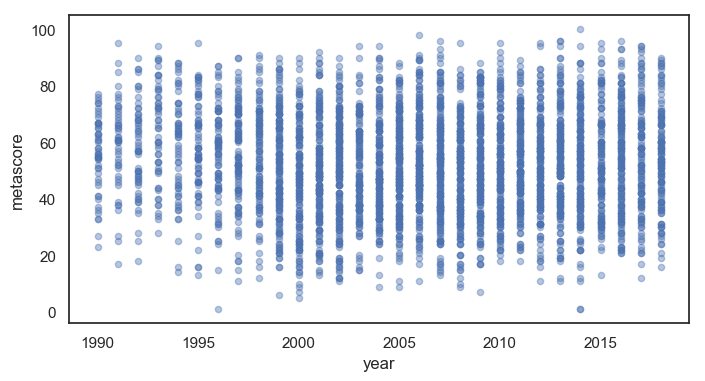

In [156]:
test.plot(kind="scatter",
                      x="year",
                      y="metascore",
                      alpha=0.4)

plt.show()

In [157]:
#fig, ax = plt.subplots(figsize = (9,5))
#sns.distplot(df_90_income.tomatometer_score,bins = 50);
#plt.title("Distribution of metascore among movies", size = 10);


# Error: ould not convert string to float: '50%'
#df_90_income = df_90_income[(df_90_income.tomatometer_score.notnull()) &
#                      (df_90_income.audience_score.notnull())]
#sns.jointplot(x=df_90_income['year'], y=df_90_income['tomatometer_score'],
#              kind="kde").fig.set_size_inches(15,15)

# Works but not pretty 
#plt.figure(figsize=[30,10])
#sns.barplot(x=df_90_income.year, y=df_90_income.metascore, data=df_90_income)

In [158]:
# Ideas:
#1) Look at gender or race in director (men vs women) (balck vs white)

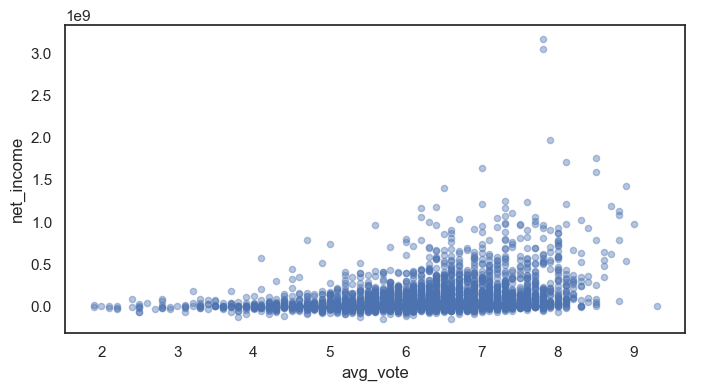

In [159]:
df_budget.plot(kind="scatter",
                      x="avg_vote",
                      y="net_income",
                      alpha=0.4)